In [1]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import configparser
import talib as tb

In [2]:
conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
hk=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)
begin='2014-01-01'
dt1=dt.datetime.now()
_fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol']
df1=hk.get_main_contract_bars('HSI', _fields, begin)
print(dt.datetime.now()-dt1)

0:00:59.535022


In [127]:
dt1=dt.datetime.now()
df1['MACD'],df1['DIFF'],df1['DEA']=tb.MACD(df1.close.values,fastperiod=6,slowperiod=12,signalperiod=9)
df1['MA30']=tb.EMA(df1.close.values,timeperiod=30)
df1['MA60']=tb.EMA(df1.close.values,timeperiod=60)
df1['CHG']=df1['close']-df1['open']
df1['STD60']=tb.STDDEV(df1['CHG'].values,timeperiod=60)
df1['STD1']=df1['CHG']/df1['STD60']
print(dt.datetime.now()-dt1)
df1=pd.read_pickle("pkl/hsi.pkl")

0:00:00.102058


In [188]:
# df1.to_pickle("pkl/hsi.pkl")
df1=pd.read_pickle("pkl/hsi.pkl")

In [163]:
#没有区分每个交易日
time1=dt.datetime.now()
ref_MACD=0
MACD_In=0
MA60_In=0
Dict_MACD={}
Dict_MA60={}
Res_MACD=[]
Res_MA60=[]
Dict_MACD['State']=0
Dict_MACD['StateE']=0
MACD_NO=0
MACD_NO1=0
MACD_NO2=0
Dict_MA60['State']=0
ref_Close=0
dt1=dt.time(9,15,0)
dt2=dt.time(16,30,0)
cont={}
for i,row in df1.iterrows():
    #State 1>ma60,2<ma6 MACD红|3>ma60,4<ma60 MACD 绿区
    #持续MACD红区
    cont['MACD1']=row["MACD"]>0 and Dict_MACD['State'] in [1,2]
    #持续MACD绿区
    cont['MACD2']=row['MACD']<0 and Dict_MACD['State'] in [3,4]
    #转MACD红区
    cont['MACD3']=row['MACD']>0 and Dict_MACD['State'] in [0,3,4]
    #l转MACD绿区
    cont['MACD4']=row['MACD']<0 and Dict_MACD['State'] in [0,1,2]
    
#     print(row["MACD"],cont)
    #持续MA60红区
    cont['MA60a']=row["close"]>row['MA60'] and Dict_MA60['State']==1
    #持续MA60绿区
    cont['MA60b']=row['close']<row['MA60'] and Dict_MA60['State']==-1
    #转MA60红区
    cont['MA60c']=row['close']>=row['MA60'] and Dict_MA60['State']<=0
    #l转MA60绿区
    cont['MA60d']=row['close']<row['MA60'] and Dict_MA60['State']>=0
    
    #MA60计算
    if cont['MA60c'] or cont['MA60d']:
        #rec
        if MA60_In>0:
            Dict_MA60['Close']=row['MA60']
            Dict_MA60['End']=i
            if i.time()>dt2 or i.time()<dt1:
                Dict_MA60['Day']=0
            else:
                Dict_MA60['Day']=1
            Res_MA60.append(Dict_MA60)
            Dict_MA60={}
        Dict_MA60['Index']=MA60_In
        Dict_MA60['Begin']=i
        Dict_MA60['Open']=row['close']
        Dict_MA60['High']=row['close']
        Dict_MA60['Low']=row['close']
        Dict_MA60['Count']=1
        Dict_MA60['Std1']=1 if row['STD1']>=1.5 else 0
        Dict_MA60['Std2']=1 if row['STD1']<=-1.5 else 0
        MA60_In+=1
        Dict_MA60['State']=1 if cont['MA60c'] else -1
        MACD_NO=0
        MACD_NO1=0
        MACD_NO2=0
    elif cont['MA60a'] or cont['MA60b']:
        Dict_MA60['Count']+=1
        
        if row['STD1']>=1.5:
            Dict_MA60['Std1']+=1
        elif row['STD1']<=-1.5:
            Dict_MA60['Std2']+=1
            
        if row['close']>Dict_MA60['High']:
            Dict_MA60['High']=row['close']
        elif row['close']<Dict_MA60['Low']:
            Dict_MA60['Low']=row['close']
    
    #MACD计算
    if cont['MACD3'] or cont['MACD4']:
        #rec
        #Type 1 B&E>0 3 B>0&E<0 2 B&E<0 4 B<0&E>0
        if MACD_In>0:
            Dict_MACD['Close']=row['close']
            Dict_MACD['End']=i
#             print(Dict_MACD['Type'],row["close"],row["MA60"])
            if row["MACD"]>0 and row["close"]>row['MA60']:
                MACD_NO2+=1
                Dict_MACD['No']=MACD_NO2
                Dict_MACD['StateE']=1
            elif row["MACD"]>0 and row["close"]<=row['MA60']:
                MACD_NO2+=-1
                Dict_MACD['No']=MACD_NO2
                Dict_MACD['StateE']=2
            elif row["MACD"]<=0 and row["close"]>row['MA60']:
                MACD_NO1+=1
                Dict_MACD['No']=MACD_NO1
                Dict_MACD['StateE']=3
            elif row["MACD"]<=0 and row["close"]<=row['MA60']:
                MACD_NO1+=-1
                Dict_MACD['No']=MACD_NO1
                Dict_MACD['StateE']=4
            else:
                Dict_MACD['State']=0
                
            if i.time()>dt2 or i.time()<dt1:
                Dict_MACD['Day']=0
            else:
                Dict_MACD['Day']=1
            Res_MACD.append(Dict_MACD)
            Dict_MACD={}
#             Dict_MACD['Type']=0
            
        Dict_MACD['Index']=MACD_In
        Dict_MACD['Begin']=i
        Dict_MACD['Date']=i.date()
        Dict_MACD['Open']=row['close']
        Dict_MACD['High']=row['close']
        Dict_MACD['Low']=row['close']
        Dict_MACD['Count']=1
        Dict_MACD['Std1']=1 if row['STD1']>=1.5 else 0
        Dict_MACD['Std2']=1 if row['STD1']<=-1.5 else 0
        MACD_In+=1
#         print(MACD_In)
        if row["MACD"]>0 and row["close"]>row['MA60']:
            Dict_MACD['State']=1
        elif row["MACD"]>0 and row["close"]<=row['MA60']:
            Dict_MACD['State']=2
        elif row["MACD"]<=0 and row["close"]>row['MA60']:
            Dict_MACD['State']=3
        elif row["MACD"]<=0 and row["close"]<=row['MA60']:
            Dict_MACD['State']=4
        else:
            Dict_MACD['State']=0
        Dict_MACD['Type']=1 if row["close"]>row['MA60'] else 2
    elif cont['MACD1'] or cont['MACD2']:
        Dict_MACD['Count']+=1
        ref_Close=row['close']
        
        if row['STD1']>=1.5:
            Dict_MACD['Std1']+=1
        elif row['STD1']<=-1.5:
            Dict_MACD['Std2']+=1
            
        if row['close']>Dict_MACD['High']:
            Dict_MACD['High']=row['close']
        elif row['close']<Dict_MACD['Low']:
            Dict_MACD['Low']=row['close']
time2=dt.datetime.now()
print(time2-time1)

0:02:50.292639


In [276]:
def CalcDay(Date):
#     Date='2014-01-03'
    F2=df1[str(Date)]

    #记录结果
    Dict_MACD={}
    Dict_MA60={}
    Res={}
    Res['MACD']=[]
    Res['MA60']=[]
    #Begin Macd State
    Dict_MACD['StateB']=0
    #End MACD State
    Dict_MACD['StateE']=0
    Dict_MA60['State']=0
    #常用参数
    Para={}
    Para['Macd_Index']=0
    Para['Ma60_Index']=0
    Para['Macd_CNT1']=0
    Para['Macd_CNT2']=0
    Para['T1']=dt.time(9,15,0)
    Para['T2']=dt.time(16,30,0)
    Ref=(F2.index.time>=Para['T1']) & (F2.index.time<=Para['T2'])
    #判断的条件
    Cont={}
    for i,row in F2[Ref].iterrows():
        #State MACD RED 1:>ma60,2:<ma6 |MACD Geen 3:>ma60,4:<ma60
        #持续MACD红区Red
        Cont['Macd_R']=row["MACD"]>0 and Dict_MACD['StateB'] in [1,2]
        #持续MACD绿区Green
        Cont['Macd_G']=row['MACD']<0 and Dict_MACD['StateB'] in [3,4]
        #to_MACD红区Red
        Cont['Macd_2R']=row['MACD']>0 and Dict_MACD['StateB'] in [0,3,4]
        #to_MACD_Green
        Cont['Macd_2G']=row['MACD']<0 and Dict_MACD['StateB'] in [0,1,2]

        #Over ma60
        Cont['Ma60_O']=row["close"]>row['MA60'] and Dict_MA60['State']==1
        #Under Ma60
        Cont['Ma60_U']=row['close']<row['MA60'] and Dict_MA60['State']==-1
        #TO Ma60 Over
        Cont['Ma60_2O']=row['close']>=row['MA60'] and Dict_MA60['State']<=0
        #To Ma60 Under
        Cont['Ma60_2U']=row['close']<row['MA60'] and Dict_MA60['State']>=0

        #calc ma60
        if Cont['Ma60_2O'] or Cont['Ma60_2U']:
            #Ma60上下转换
            if Dict_MA60['State'] in[1,-1]:
                Dict_MA60['Close']=row['MA60']
                Dict_MA60['End']=i.time()
                Dict_MA60['Diff']=Dict_MA60['Close']-Dict_MA60['Open']
                Res['MA60'].append(Dict_MA60)
                Dict_MA60={}
            Dict_MA60['No']=Para['Ma60_Index']
            Dict_MA60['Date']=i.date()
            Dict_MA60['Begin']=i.time()
            Dict_MA60['Open']=row['close']
            Dict_MA60['High']=row['close']
            Dict_MA60['Low']=row['close']
            Dict_MA60['Count']=1
            Dict_MA60['Std1']=1 if row['STD1']>=1.5 else 0
            Dict_MA60['Std2']=1 if row['STD1']<=-1.5 else 0
            Dict_MA60['State']=1 if Cont['Ma60_2O'] else -1
            Para['Ma60_Index']+=1
            Para['Macd_CNT1']=0
            Para['Macd_CNT2']=0
        elif Cont['Ma60_O'] or Cont['Ma60_U']:
            Dict_MA60['Count']+=1
            if row['STD1']>=1.5:
                Dict_MA60['Std1']+=1
            elif row['STD1']<=-1.5:
                Dict_MA60['Std2']+=1
            if row['close']>Dict_MA60['High']:
                Dict_MA60['High']=row['close']
            elif row['close']<Dict_MA60['Low']:
                Dict_MA60['Low']=row['close']

        #MACD计算
        if Cont['Macd_2R'] or Cont['Macd_2G']:
            #StateB[1：macd>0 & close<ma60,2:macd>0&c>ma60,3:macd<0 & c>ma60,4:macd<0 & c<ma60]
            if Dict_MACD['StateB']>0:
                Dict_MACD['Close']=row['close']
                Dict_MACD['End']=i.time()
                Dict_MACD['Diff']=Dict_MACD['Close']-Dict_MACD['Open']
                if row["MACD"]>0 and row["close"]>row['MA60']:
                    Para['Macd_CNT2']+=1
                    Dict_MACD['No']=Para['Macd_CNT2']
                    Dict_MACD['StateE']=1
                elif row["MACD"]>0 and row["close"]<=row['MA60']:
                    Para['Macd_CNT2']+=-1
                    Dict_MACD['No']=Para['Macd_CNT2']
                    Dict_MACD['StateE']=2
                elif row["MACD"]<=0 and row["close"]>row['MA60']:
                    Para['Macd_CNT1']+=1
                    Dict_MACD['No']=Para['Macd_CNT1']
                    Dict_MACD['StateE']=3
                elif row["MACD"]<=0 and row["close"]<=row['MA60']:
                    Para['Macd_CNT1']+=-1
                    Dict_MACD['No']=Para['Macd_CNT1']
                    Dict_MACD['StateE']=4
                else:
                    Dict_MACD['State']=0

                Res['MACD'].append(Dict_MACD)
                Dict_MACD={}

            Dict_MACD['Begin']=i
            Dict_MACD['Date']=i.date()
            Dict_MACD['Ma60_No']=0 if Para['Ma60_Index']==0 else Dict_MA60['No']
            Dict_MACD['Open']=row['close']
            Dict_MACD['High']=row['close']
            Dict_MACD['Low']=row['close']
            Dict_MACD['Count']=1
            Dict_MACD['Std1']=1 if row['STD1']>=1.5 else 0
            Dict_MACD['Std2']=1 if row['STD1']<=-1.5 else 0

            if row["MACD"]>0 and row["close"]>row['MA60']:
                Dict_MACD['StateB']=1
            elif row["MACD"]>0 and row["close"]<=row['MA60']:
                Dict_MACD['StateB']=2
            elif row["MACD"]<=0 and row["close"]>row['MA60']:
                Dict_MACD['StateB']=3
            elif row["MACD"]<=0 and row["close"]<=row['MA60']:
                Dict_MACD['StateB']=4
            else:
                Dict_MACD['StateB']=0
        elif Cont['Macd_R'] or Cont['Macd_G']:
            Dict_MACD['Count']+=1
            if row['STD1']>=1.5:
                Dict_MACD['Std1']+=1
            elif row['STD1']<=-1.5:
                Dict_MACD['Std2']+=1

            if row['close']>Dict_MACD['High']:
                Dict_MACD['High']=row['close']
            elif row['close']<Dict_MACD['Low']:
                Dict_MACD['Low']=row['close']
    return Res

In [279]:
time1=dt.datetime.now()
dList=df1.datetime.dt.date.unique()
Res1=[]
Res2=[]
for dd in dList:
    res=CalcDay(dd)
    for a in res["MA60"]:
        Res1.append(a)
    for b in res["MACD"]:
        Res2.append(b)
time2=dt.datetime.now()
print(time2-time1)
R1=pd.DataFrame(Res1)
R2=pd.DataFrame(Res2)
R2.head()

0:01:29.688447


,Begin,Close,Count,Date,Diff,End,High,Low,Ma60_No,No,Open,StateB,StateE,Std1,Std2
0,2014-01-02 10:14:00,23350.0,4,2014-01-02,51.0,10:18:00,23336.0,23299.0,0,-1,23299.0,4,2,0,0
1,2014-01-02 10:18:00,23316.0,17,2014-01-02,-34.0,10:35:00,23350.0,23337.0,0,-1,23350.0,2,4,0,0
2,2014-01-02 10:35:00,23237.0,32,2014-01-02,-79.0,11:07:00,23316.0,23188.0,0,-2,23316.0,4,2,2,6
3,2014-01-02 11:07:00,23210.0,13,2014-01-02,-27.0,11:20:00,23244.0,23222.0,0,-2,23237.0,2,4,0,0
4,2014-01-02 11:20:00,23230.0,11,2014-01-02,20.0,11:31:00,23216.0,23184.0,0,-3,23210.0,4,2,0,0


In [282]:
Calc=['sum','max','min','mean','std','count']
# Ma60[(Ma60.State==1) & (Ma60.Day==0)].groupby('Std1')['Diff'].agg(Calc)
R1[R1.State==1].groupby('No')['Diff'].agg(Calc)
R1[R1.State==-1].groupby('No')['Diff'].agg(Calc)

,sum,max,min,mean,std,count
No,,,,,,
0,-5606.859388,303.318723,-603.287840,-9.360366,95.575675,599
1,-9019.343169,50.710085,-1066.841121,-13.052595,72.929250,691
2,-5739.784868,42.094786,-656.030108,-9.582279,52.530980,599
3,-4490.567249,37.103400,-389.701536,-6.508068,44.712969,690
4,-4876.608380,48.817642,-1015.129616,-8.141249,57.122514,599
5,-3045.237712,40.177898,-273.016746,-4.419793,32.152959,689
6,-3453.377874,52.515902,-551.319713,-5.774879,39.710254,598
7,-3992.281429,32.283880,-477.001404,-5.853785,37.170691,682
8,-2079.393609,44.088452,-227.592189,-3.512489,26.250555,592


In [283]:
R1[R1.State==1].groupby('No')['Diff'].agg(Calc)

,sum,max,min,mean,std,count
No,,,,,,
0,4385.358690,603.291834,-223.709106,6.346395,90.015449,691
1,5062.228831,342.705025,-52.548476,8.451133,44.999870,599
2,5555.870879,412.333551,-86.677050,8.040334,43.706106,691
3,4804.402413,487.521872,-53.744787,8.020705,44.615072,599
4,4864.131262,680.620059,-48.483211,7.049466,48.757670,690
5,4517.445216,499.116418,-43.443354,7.541645,44.988930,599
6,4193.962804,423.288704,-50.097627,6.113648,38.140782,686
7,2870.276157,266.584032,-43.389447,4.815900,29.856363,596
8,2307.180938,324.747029,-45.645096,3.402922,29.473414,678


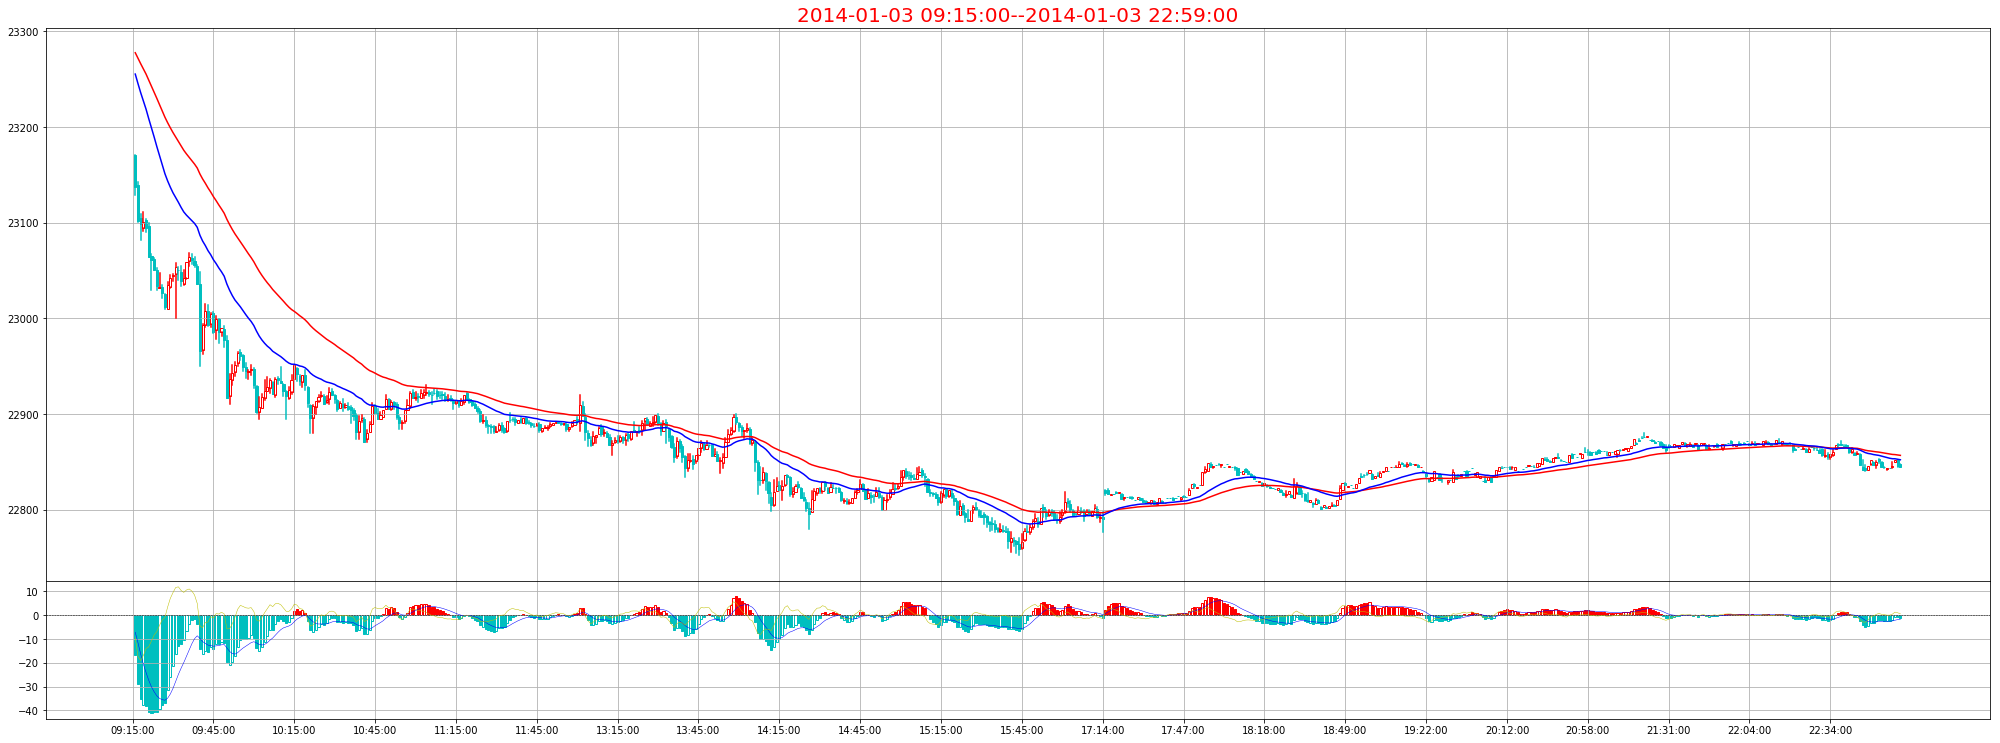

In [222]:
DrawKline('2014/1/3')

In [186]:
Ma60=pd.DataFrame(Res_MA60)
Ma60['Diff']=Ma60['Close']-Ma60['Open']
Ma60.head()

,Begin,Close,Count,Day,End,High,Index,Low,Open,State,Std1,Std2,Diff
0,2014-01-02 10:14:00,23236.056955,89,1,2014-01-02 11:43:00,23350.0,0,23184.0,23299.0,-1,2,6,-62.943045
1,2014-01-02 11:43:00,23235.825580,1,1,2014-01-02 11:44:00,23243.0,1,23243.0,23243.0,1,0,0,-7.174420
2,2014-01-02 11:44:00,23235.280723,3,1,2014-01-02 11:47:00,23229.0,2,23227.0,23229.0,-1,0,0,6.280723
3,2014-01-02 11:47:00,23257.329920,26,1,2014-01-02 13:13:00,23293.0,3,23236.0,23236.0,1,2,0,21.329920
4,2014-01-02 13:13:00,23257.483037,1,1,2014-01-02 13:14:00,23255.0,4,23255.0,23255.0,-1,0,1,2.483037


In [187]:
Calc=['sum','max','min','mean','std','count']
# Ma60[(Ma60.State==1) & (Ma60.Day==0)].groupby('Std1')['Diff'].agg(Calc)
Ma60[Ma60.Day==1].groupby('State')['Diff'].agg(Calc)

,sum,max,min,mean,std,count
State,,,,,,
-1,-114882.090881,303.318723,-1385.882749,-6.110424,44.461035,18801
1,114962.007296,966.291834,-223.709106,6.106555,39.984369,18826


In [189]:
MACD=pd.DataFrame(Res_MACD)
MACD['Diff']=MACD['Close']-MACD['Open']
MACD.head(5)

,Begin,Close,Count,Date,Day,End,High,Index,Low,No,Open,State,StateE,Std1,Std2,Type,Diff
0,2014-01-02 09:34:00,23439.0,1,2014-01-02,1,2014-01-02 09:35:00,23466.0,0,23466.0,NaN,23466.0,0,0.0,0,0,2,-27.0
1,2014-01-02 09:35:00,23430.0,1,2014-01-02,1,2014-01-02 09:36:00,23439.0,1,23439.0,NaN,23439.0,0,NaN,0,0,2,-9.0
2,2014-01-02 09:36:00,23411.0,1,2014-01-02,1,2014-01-02 09:37:00,23430.0,2,23430.0,NaN,23430.0,0,NaN,0,0,2,-19.0
3,2014-01-02 09:37:00,23416.0,1,2014-01-02,1,2014-01-02 09:38:00,23411.0,3,23411.0,NaN,23411.0,0,NaN,0,0,2,5.0
4,2014-01-02 09:38:00,23406.0,1,2014-01-02,1,2014-01-02 09:39:00,23416.0,4,23416.0,NaN,23416.0,0,NaN,0,0,2,-10.0


In [185]:
Calc=['sum','max','min','mean','std','count']
MACD[(MACD.State==1) & (MACD.Day==1)].groupby('Std1')['Diff'].agg(Calc)
MACD[(MACD.State==-1)].groupby('No')['Diff'].agg(Calc)
# MACD[(MACD.State==-1) & (MACD.Day==1)].groupby('Std2')['Diff'].agg(Calc)
MACD.groupby(['State','StateE'])['Diff'].agg(Calc)
# MACD.groupby(['Date','State'])['Diff'].agg(Calc)

sum    max    min       mean        std  count
State StateE                                                     
0     0.0        -27.0  -27.0  -27.0 -27.000000        NaN      1
      4.0        -11.0  -11.0  -11.0 -11.000000        NaN      1
1     3.0     143333.0  589.0 -235.0  11.096462  40.876158  12917
      4.0    -140057.0   76.0 -566.0 -14.295907  19.704004   9797
2     3.0      95392.0  893.0    2.0  51.899891  65.373187   1838
      4.0    -109292.0  116.0 -992.0  -9.516064  22.150675  11485
3     1.0     110375.0  820.0 -143.0   8.556202  17.462512  12900
      2.0     -95437.0   -1.0 -775.0 -51.448518  61.800610   1855
4     1.0     141439.0  594.0  -79.0  14.411963  20.084387   9814
      2.0    -139951.0  133.0 -810.0 -12.203610  46.921934  11468

In [49]:
MACD.groupby(['StateE'])['Diff'].agg(Calc)

,sum,max,min,mean,std,count
StateE,,,,,,
0.0,-27.0,-27.0,-27.0,-27.000000,NaN,1
1.0,251814.0,820.0,-143.0,11.086290,18.864577,22714
2.0,-235388.0,133.0,-810.0,-17.667793,51.100154,13323
3.0,238725.0,893.0,-235.0,16.179261,46.651799,14755
4.0,-249360.0,116.0,-992.0,-11.716393,21.193059,21283


In [51]:
MACD.groupby(['State','StateE','No'])['Diff'].agg(Calc)

sum    max    min        mean         std  count
State StateE No                                                          
0     4.0    -1.0      -11.0  -11.0  -11.0  -11.000000         NaN      1
1     3.0     1.0   116956.0  589.0 -235.0   19.709471   45.025444   5934
              2.0    14158.0  380.0 -162.0    4.096644   35.122822   3456
              3.0     6857.0  513.0  -80.0    3.954441   36.238753   1734
              4.0     3488.0  559.0  -62.0    3.986286   40.517022    875
              5.0      272.0  236.0  -95.0    0.593886   27.326875    458
              6.0     1049.0  248.0  -31.0    4.662222   35.649981    225
              7.0      365.0  130.0  -34.0    3.201754   24.599511    114
              8.0      136.0   65.0  -23.0    2.060606   18.704075     66
              9.0      -65.0  111.0  -19.0   -2.031250   22.194862     32
              10.0     215.0  121.0  -32.0   19.545455   45.169378     11
              11.0     -95.0   -1.0  -28.0  -13.571429    9.071147      7
              12.0      17.0   20.0  -10.0    4.250000   14.522970      4
              13.0     -20.0  -20.0  -20.0  -20.000000         NaN      1
      4.0    -1.0  -140057.0   76.0 -566.0  -14.295907   19.704004   9797
2     3.0     1.0    95392.0  893.0    2.0   51.899891   65.373187   1838
      4.0    -13.0     -17.0  -17.0  -17.0  -17.000000         NaN      1
             -12.0     -31.0  -10.0  -21.0  -15.500000    7.778175      2
             -11.0     -67.0  -24.0  -43.0  -33.500000   13.435029      2
             -10.0     -50.0   -1.0  -17.0   -8.333333    5.278889      6
             -9.0     -406.0    2.0 -183.0  -19.333333   38.612606     21
             -8.0     -513.0    0.0  -43.0  -11.400000    9.978158     45
             -7.0    -1108.0    0.0 -136.0  -12.735632   16.518108     87
             -6.0    -2038.0    3.0 -214.0  -13.233766   18.859921    154
             -5.0    -4151.0   19.0 -230.0  -13.177778   18.851924    315
             -4.0    -9056.0   19.0 -324.0  -14.083981   21.638616    643
             -3.0   -18051.0   33.0 -434.0  -13.166302   17.774666   1371
             -2.0   -41301.0   40.0 -992.0  -13.915431   23.220139   2968
             -1.0   -32503.0  116.0 -766.0   -5.537138   22.169883   5870
3     1.0     1.0    34776.0  820.0 -143.0    5.432901   20.932725   6401
              2.0    40198.0  229.0  -17.0   12.195995   12.594305   3296
              3.0    17823.0  141.0  -20.0   11.223552   10.813759   1588
              4.0     8912.0  263.0  -34.0   11.367347   16.361505    784
              5.0     4205.0   67.0  -53.0   10.281174   10.263999    409
              6.0     2106.0   78.0   -5.0   10.273171   10.058335    205
              7.0     1072.0   61.0   -1.0   10.018692    9.856500    107
              8.0      677.0   65.0    0.0   11.474576   10.412784     59
              9.0      295.0   38.0   -4.0   10.535714    9.271550     28
              10.0     135.0   35.0    2.0   12.272727    9.940733     11
              11.0      94.0   25.0    5.0   15.666667    7.633261      6
              12.0      76.0   33.0    4.0   15.200000   10.986355      5
              13.0       6.0    6.0    6.0    6.000000         NaN      1
      2.0    -1.0   -95437.0   -1.0 -775.0  -51.448518   61.800610   1855
4     1.0     1.0   141439.0  594.0  -79.0   14.411963   20.084387   9814
      2.0    -13.0     -29.0   24.0  -53.0  -14.500000   54.447222      2
             -12.0    -228.0    0.0 -228.0 -114.000000  161.220346      2
             -11.0    -221.0   15.0 -236.0 -110.500000  177.483802      2
             -10.0     -16.0   37.0  -76.0   -2.285714   34.754924      7
             -9.0     -101.0   22.0  -98.0   -4.590909   23.661621     22
             -8.0     -738.0   38.0 -131.0  -14.470588   39.895540     51
             -7.0       98.0   44.0 -173.0    1.020833   26.193201     96
             -6.0     -721.0   40.0 -171.0   -4.027933   32.979638    179
             -5.0     -648.0 

In [180]:
dt1=dt.datetime(2014,1,3).date()
dt2=MACD.Date[0]
MACD[MACD.Date==dt1]

,Begin,Close,Count,Date,Day,End,High,Index,Low,No,Open,State,StateE,Std1,Std2,Type,Diff
101,2014-01-03 10:14:00,22911.0,5,2014-01-03,1,2014-01-03 10:19:00,22951.0,101,22930.0,-3.0,22951.0,2,4.0,0,0,2,-40.0
102,2014-01-03 10:19:00,22904.0,28,2014-01-03,1,2014-01-03 10:47:00,22923.0,102,22871.0,-3.0,22911.0,4,2.0,0,1,2,-7.0
103,2014-01-03 10:47:00,22890.0,6,2014-01-03,1,2014-01-03 10:53:00,22916.0,103,22897.0,-4.0,22904.0,2,4.0,0,0,2,-14.0
104,2014-01-03 10:53:00,22909.0,3,2014-01-03,1,2014-01-03 10:56:00,22904.0,104,22890.0,-4.0,22890.0,4,2.0,0,0,2,19.0
105,2014-01-03 10:56:00,22911.0,17,2014-01-03,1,2014-01-03 11:13:00,22923.0,105,22909.0,-5.0,22909.0,2,4.0,0,0,2,2.0
106,2014-01-03 11:13:00,22896.0,26,2014-01-03,1,2014-01-03 11:39:00,22920.0,106,22881.0,-5.0,22911.0,4,2.0,0,0,2,-15.0
107,2014-01-03 11:39:00,22890.0,2,2014-01-03,1,2014-01-03 11:41:00,22896.0,107,22891.0,-6.0,22896.0,2,4.0,0,0,2,-6.0
108,2014-01-03 11:41:00,22892.0,10,2014-01-03,1,2014-01-03 11:51:00,22890.0,108,22883.0,-6.0,22890.0,4,2.0,0,0,2,2.0
109,2014-01-03 11:51:00,22884.0,4,2014-01-03,1,2014-01-03 11:55:00,22892.0,109,22889.0,-7.0,22892.0,2,4.0,0,0,2,-8.0
110,2014-01-03 11:55:00,22894.0,3,2014-01-03,1,2014-01-03 11:58:00,22890.0,110,22884.0,-7.0,22884.0,4,2.0,0,0,2,10.0


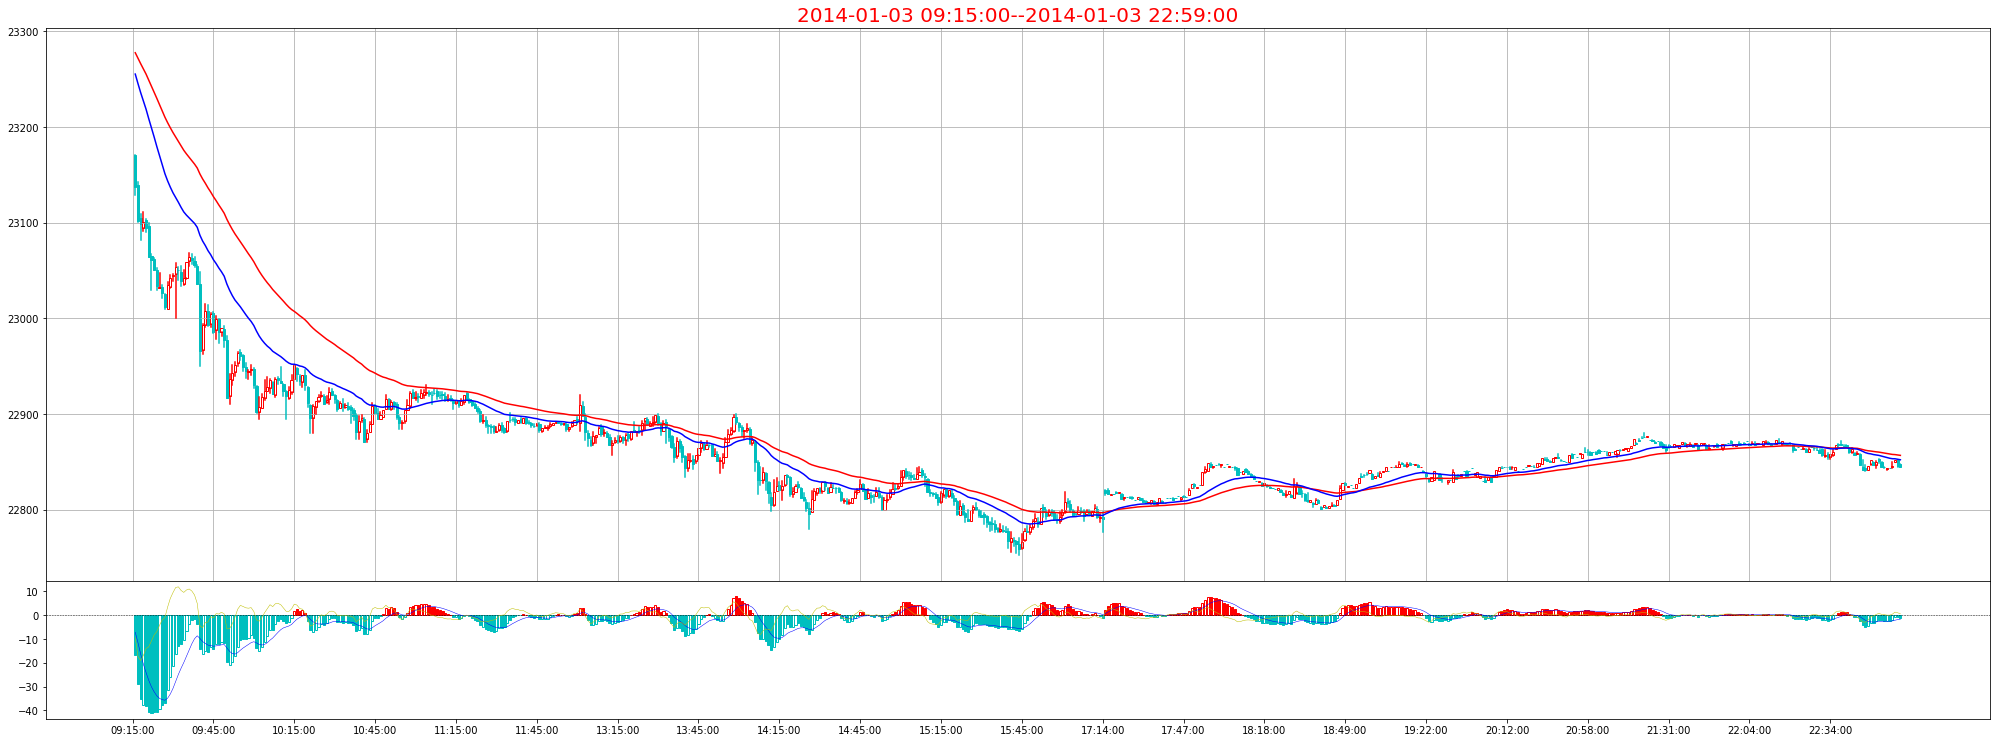

In [181]:
DrawKline('2014/1/3')

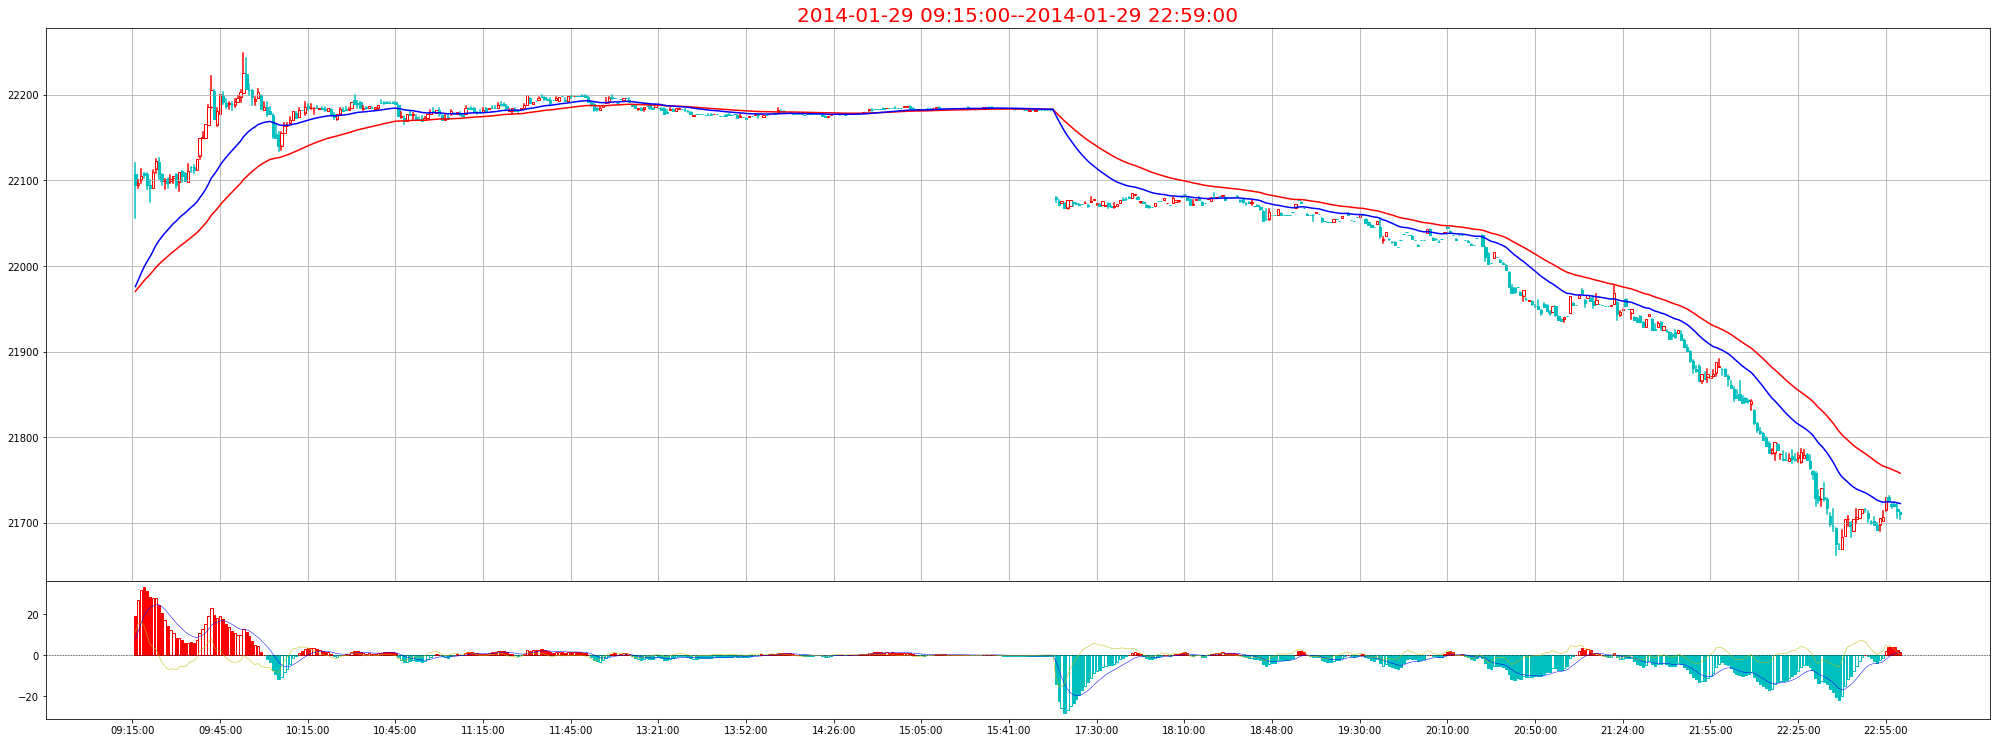

In [161]:
DrawKline('2014/1/29')

In [32]:
df2[df2.State==1]['Count'].agg(['max','min','mean','std'])

max     157.00000
min       1.00000
mean     13.26239
std      13.48442
Name: Count, dtype: float64

In [44]:
df2['hh']=df2.apply(lambda x:x.Begin.time().hour,axis=1)
df2[df2.State==1].groupby('hh')['Diff'].agg(['max','min','mean','std','count'])

,max,min,mean,std,count
hh,,,,,
0,589.0,-992.0,-1.061135,89.104121,687
9,882.0,-235.0,0.349847,59.895631,1958
10,489.0,-105.0,0.440603,40.222055,2921
11,457.0,-451.0,0.082313,35.316139,2940
12,0.0,-142.0,-38.200000,58.942345,5
13,498.0,-82.0,-1.740180,30.936376,3106
14,439.0,-108.0,-0.388438,31.849561,2958
15,380.0,-440.0,0.187910,38.575829,2895
16,329.0,-566.0,1.058598,41.184382,1041


In [24]:
time1=dt.time(9,15,0)
time2=dt.time(16,30,0)
newDF=df1[(df1.datetime.dt.time>=time1)&(df1.datetime.dt.time<=time2)]
newDF.head(10)

,datetime,code,open,high,low,close,MACD,MACD1,MACD2,MA30,MA60,CHG,STD60,STD1
datetime,,,,,,,,,,,,,,
2014-01-02 09:15:00,2014-01-02 09:15:00,HSI1401,23414.0,23416.0,23370.0,23376.0,NaN,NaN,NaN,NaN,NaN,-38.0,NaN,NaN
2014-01-02 09:16:00,2014-01-02 09:16:00,HSI1401,23376.0,23394.0,23360.0,23394.0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN
2014-01-02 09:17:00,2014-01-02 09:17:00,HSI1401,23395.0,23444.0,23391.0,23431.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN
2014-01-02 09:18:00,2014-01-02 09:18:00,HSI1401,23432.0,23435.0,23419.0,23423.0,NaN,NaN,NaN,NaN,NaN,-9.0,NaN,NaN
2014-01-02 09:19:00,2014-01-02 09:19:00,HSI1401,23426.0,23426.0,23390.0,23401.0,NaN,NaN,NaN,NaN,NaN,-25.0,NaN,NaN
2014-01-02 09:20:00,2014-01-02 09:20:00,HSI1401,23401.0,23405.0,23384.0,23403.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2014-01-02 09:21:00,2014-01-02 09:21:00,HSI1401,23403.0,23418.0,23401.0,23415.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
2014-01-02 09:22:00,2014-01-02 09:22:00,HSI1401,23415.0,23430.0,23415.0,23430.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN
2014-01-02 09:23:00,2014-01-02 09:23:00,HSI1401,23430.0,23497.0,23430.0,23456.0,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN


In [96]:
def Calc(Date):
# Date='2014-01-06'
    D1=newDF[str(Date)]
    STD=1.5
    Res={}
    Res['STD_CNT']=0
    Res['State']=0
    Res['Trade']=[]
    Trade={}
    Trade['Open']=[]
    for Row in D1.iterrows():
        Rec=Row[1]

        if Rec['MACD']<0 and Res['State']==2:
            Trade['Date']=Date
            Trade['Close']=Rec['close']
            Trade['Profit']=[Rec['close']-i for i in Trade['Open']]
            Trade['Profits']=sum(Trade['Profit'])
            Trade['Count']=len(Trade['Profit'])
            Res['Trade'].append(Trade)
#             print(Trade)
            Res['State']=0
            Res['STD_CNT']=0
            Trade={}
            Trade['Open']=[]
        elif Rec['MACD']<0:
            Res['State']=0
            Res['STD_CNT']=0
            Trade={}
            Trade['Open']=[]
        elif Res['State']==0:
            Res['State']=1
        if Rec['STD1']>STD and Res['State']>0:
            Res['STD_CNT']+=1
            if Res['STD_CNT']>=3:
                Trade['Open'].append(Rec['close'])
    #             print(Row[0],Res['STD_CNT'],Rec['close'])
                Res['State']=2
    return Res['Trade']

In [101]:
dl=newDF.datetime.dt.date.unique()
#固定止损
Data=[]
time1=dt.datetime.now()
for dd in dl:
    get=Calc(dd)
    if len(get)>0:
        for i in get:
            Data.append(i)
time2=dt.datetime.now()
print(time2-time1)

0:00:34.545976


In [115]:
F=pd.DataFrame(Data)
# Data
F.head()

,Close,Count,Date,Open,Profit,Profits
0,23354.0,5,2014-01-02,"[23292.0, 23317.0, 23327.0, 23357.0, 23377.0]","[62.0, 37.0, 27.0, -3.0, -23.0]",100.0
1,22654.0,1,2014-01-06,[22669.0],[-15.0],-15.0
2,22726.0,8,2014-01-06,"[22654.0, 22666.0, 22682.0, 22690.0, 22712.0, ...","[72.0, 60.0, 44.0, 36.0, 14.0, -2.0, -6.0, -12.0]",206.0
3,22689.0,1,2014-01-07,[22702.0],[-13.0],-13.0
4,22758.0,5,2014-01-08,"[22780.0, 22786.0, 22798.0, 22782.0, 22793.0]","[-22.0, -28.0, -40.0, -24.0, -35.0]",-149.0


,datetime,code,open,high,low,close,MACD,MACD1,MACD2,MA30,MA60,CHG,STD60,STD1
datetime,,,,,,,,,,,,,,
2014-01-02 09:15:00,2014-01-02 09:15:00,HSI1401,23414.0,23416.0,23370.0,23376.0,NaN,NaN,NaN,NaN,NaN,-38.0,NaN,NaN
2014-01-02 09:16:00,2014-01-02 09:16:00,HSI1401,23376.0,23394.0,23360.0,23394.0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN
2014-01-02 09:17:00,2014-01-02 09:17:00,HSI1401,23395.0,23444.0,23391.0,23431.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN
2014-01-02 09:18:00,2014-01-02 09:18:00,HSI1401,23432.0,23435.0,23419.0,23423.0,NaN,NaN,NaN,NaN,NaN,-9.0,NaN,NaN
2014-01-02 09:19:00,2014-01-02 09:19:00,HSI1401,23426.0,23426.0,23390.0,23401.0,NaN,NaN,NaN,NaN,NaN,-25.0,NaN,NaN
2014-01-02 09:20:00,2014-01-02 09:20:00,HSI1401,23401.0,23405.0,23384.0,23403.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2014-01-02 09:21:00,2014-01-02 09:21:00,HSI1401,23403.0,23418.0,23401.0,23415.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
2014-01-02 09:22:00,2014-01-02 09:22:00,HSI1401,23415.0,23430.0,23415.0,23430.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN
2014-01-02 09:23:00,2014-01-02 09:23:00,HSI1401,23430.0,23497.0,23430.0,23456.0,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN


In [221]:
def DrawKline(date):
    #     date='2014-01-03'
    aa=df1[str(date)]
    aa.reset_index(drop=True,inplace=True)
    fig =plt.figure(figsize=(30, 12),facecolor='w')

    #副图是主图的比例
    w1=0.25
    w2=0.8/(1+w1)*w1
    rec1=[0.1,0.1+w2,0.9,w2/w1]
    rec2=[0.1,0.1,0.9,w2]
    ax=fig.add_axes(rec1)
    ax1=fig.add_axes(rec2,sharex=ax)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax1.get_xticklabels(), visible=True)

    #设置时间刻度
    dlist=aa.datetime.apply(lambda x:str(x.time()))
    dd=dlist.values
    d1=[i*100 for i in range(len(dd))]
    ax1.set_xticks(d1[::30])
    ax1.set_xticklabels(dd[::30])

    Kline={}
    Kline['W'] = 80
    Kline['Diff'] = 20
    Kline['WW']=100
    d=0
    rows=len(aa)
    for i in aa.iterrows():
        Row=i[1]
        x1 =(d+1)*Kline['WW']
        x2 = x1-Kline['W']/2
        O = Row['open']
        C = Row['close']
        L = Row['low']
        H = Row['high']
        hh = abs(C - O)

        if C > O:
            a = False
            y = O
            cc = 'R'
            # 上影线 下影线
            line1 = Line2D((x1, x1), (C, H), color=cc)
            line2 = Line2D((x1, x1), (O, L), color=cc)

            ax.add_line(line1)
            ax.add_line(line2)
        else:
            a = True
            y = C
            cc = 'C'
            # 影线
            line = Line2D((x1, x1), (L, H), color=cc)
            ax.add_line(line)
        hh = abs(C - O)

        # K线实体
        rec = Rectangle((x2, y), Kline['W'], hh, fill=a, color=cc)
        ax.add_patch(rec)

        if Row['MACD']>0:
            rec= Rectangle((x2, 0), Kline['W'], Row['MACD'], fill=a, color='R')
        else:
            rec= Rectangle((x2, 0), Kline['W'], Row['MACD'], fill=a, color='C')
        ax1.add_patch(rec)
        d+=1
    if "MA60" in aa.columns:
        ax.plot(aa.index*Kline['WW']+Kline['WW'],aa['MA60'],c='r')
    if "MA30" in aa.columns:
        ax.plot(aa.index*Kline['WW']+Kline['WW'],aa['MA30'],c='b')
    ax1.axhline(0,linestyle="--",linewidth=0.5,color='k')
    if "DIFF" in aa.columns:
        ax1.plot(aa.index*Kline['WW']+Kline['WW'],aa['MACD1'],c='b',linewidth=0.5)
    if "DEA" in aa.columns:
        ax1.plot(aa.index*Kline['WW']+Kline['WW'],aa['MACD2'],c='y',linewidth=0.5)

    ax.grid()
    ax1.grid()
    ax.autoscale(tight=False)
    ax.autoscale_view()

    time1=aa.iloc[0]['datetime']
    time2=aa.iloc[-1]['datetime']
    title="%s--%s" %(time1,time2)
    ax.set_title(title, fontsize=20, color='r')
    # fig.savefig("a.jpg")
    plt.show()
    fig.clear()
    plt.close(fig)

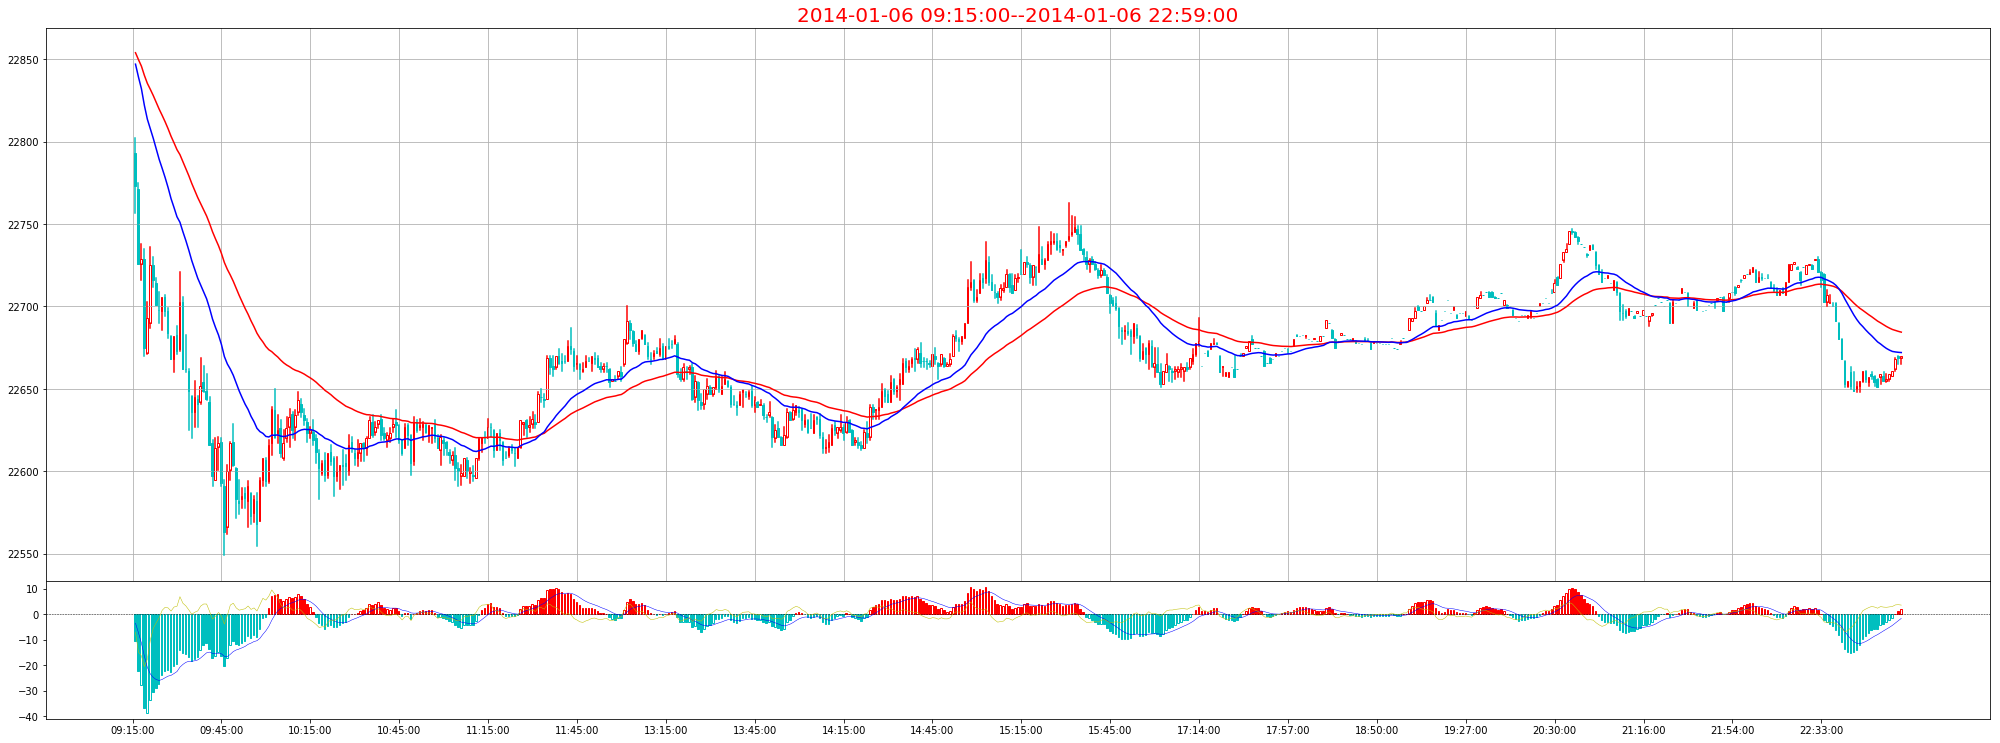

In [137]:
date=df1.datetime.apply(lambda x:x.date()).unique()
date
DrawKline('2014/1/6')

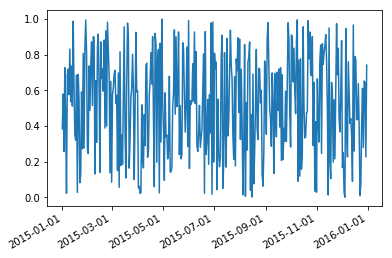

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import datetime
#面向对象方式
fig = plt.figure()
start = datetime.datetime(2015,1,1)#起始时间
stop = datetime.datetime(2016,1,1)#停止时间
delta = datetime.timedelta(days=1)
dates = mpl.dates.drange(start,stop,delta)#生成一个matplotli认得的days序列
y = np.random.rand(len(dates))
ax = plt.gca()
ax.plot_date(dates,y,linestyle = '-',marker = '')
date_format = mpl.dates.DateFormatter('%Y-%m-%d')
    #只显示年月
ax.xaxis.set_major_formatter(date_format,)
fig.autofmt_xdate()
#开启自适应
plt.show()

NameError: name 'k_width' is not defined

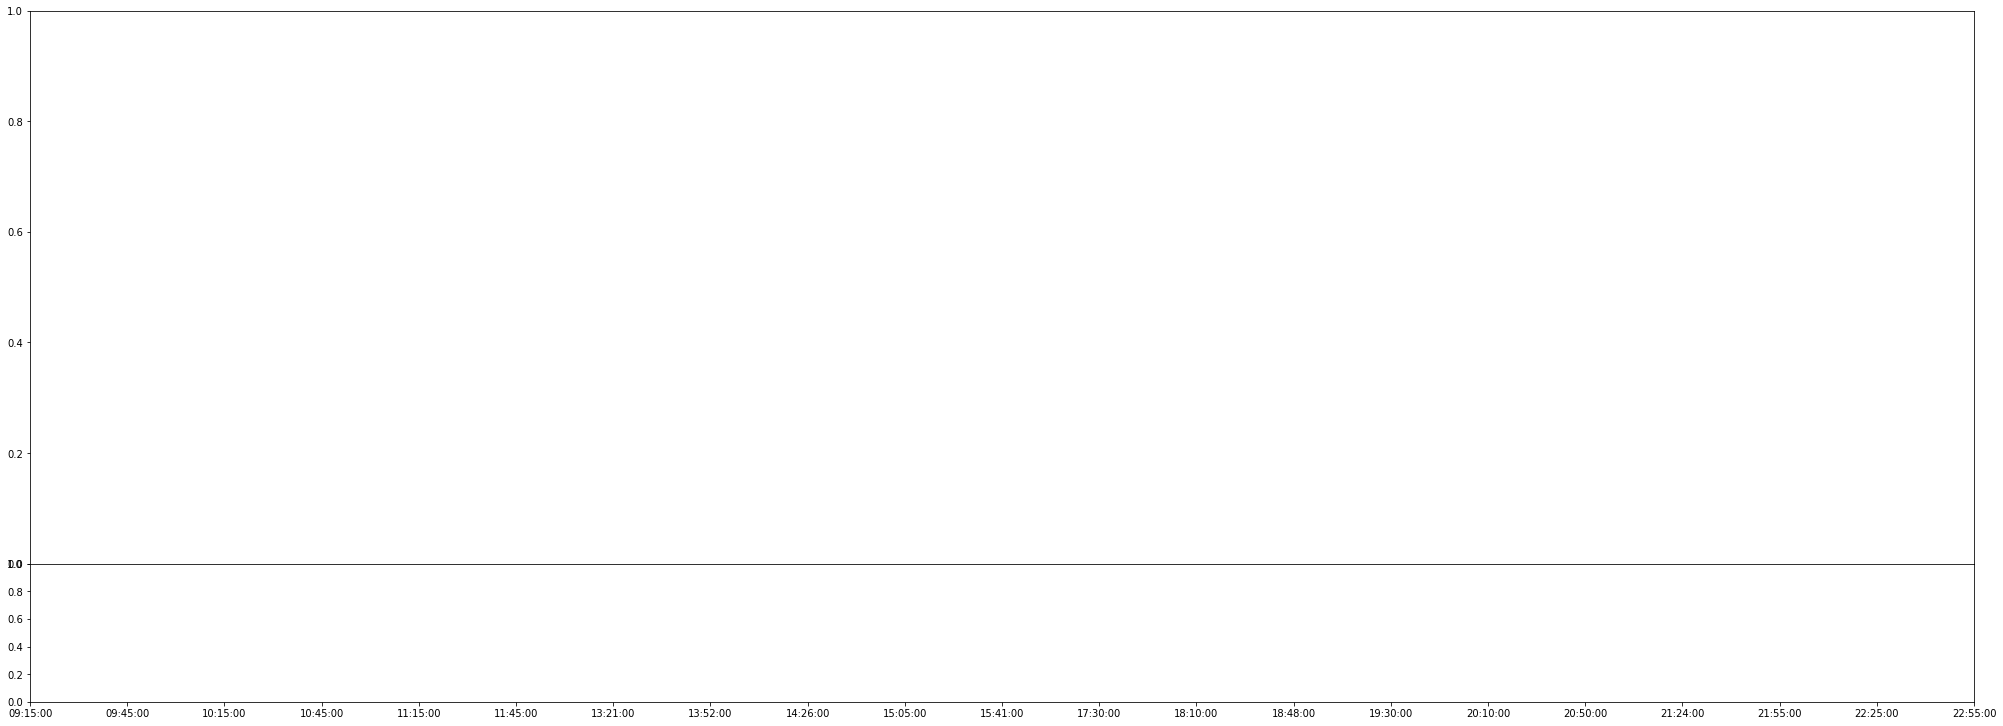

In [159]:
from kline import Kline as KK
dd=df1['2014/1/29']
K1=KK()
K1.DrawKline(dd)